In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import yaml
import omegaconf
import hydra
from hydra import initialize, compose

from framework.unifying_framework import UnifyingFramework
from framework.diffusion.consistency_framework import CMFramework
from framework.diffusion.edm_framework import EDMFramework

from utils import common_utils
from utils.fid_utils import FIDUtils
from utils.fs_utils import FSUtils

from tqdm import tqdm

import tensorflow as tf
import tensorflow_datasets as tfds

2024-02-27 05:49:36.351541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 05:49:36.351595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 05:49:36.353121: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 05:49:37.330468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/djfelrl11/diffusion/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook impor

In [2]:
# default_path = "/home/djfelrl11/diffusion/configs/config_cm_score.yaml"
config_path = "configs"
# default_path = "config_cm_score"
config_denoiser = "config_denoiser"
config_consistency = "config_consistency"
# config_path = "/home/djfelrl11/diffusion/experiments/0906_verification_unet_block_1/config.yaml"
rng = jax.random.PRNGKey(42)

with initialize(version_base=None, config_path=config_path):
    denoiser_config = compose(config_name=config_denoiser)
    consistency_config = compose(config_name=config_consistency)
denoiser_config["do_training"] = False
consistency_config["do_training"] = False
# model_type = denoiser_config.type


# Load the model
# rng, second_rng = jax.random.split(rng)
# diffusion_framework = UnifyingFramework(model_type, denoiser_config, second_rng)

rng, denoiser_rng = jax.random.split(rng, 2)
rng, consistency_rng = jax.random.split(rng, 2)
# denoiser_framework = diffusion_framework.framework
fid_utils = FIDUtils(consistency_config)
denoiser_fs_utils = FSUtils(denoiser_config)
conisstency_fs_utils = FSUtils(consistency_config)

denoiser_framework = EDMFramework(denoiser_config, denoiser_rng, denoiser_fs_utils, None)
consistency_framework = CMFramework(consistency_config, consistency_rng, conisstency_fs_utils, None)

In [3]:
sigma_max = 80
sigma_min = 0.02
rho = 7
n_timestep = denoiser_config.framework.diffusion.n_timestep
sweep_timestep = jnp.arange(n_timestep)

t_steps = (sigma_max ** (1 / rho) + sweep_timestep / (n_timestep - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho

In [4]:
num_sample = 8

datasets = common_utils.load_dataset_from_tfds(
    denoiser_config, 
    n_jitted_steps=1, x_flip=False, batch_size=num_sample, shuffle=False)

import os
tmp_saving_dir = "tmp"
if not os.path.exists(tmp_saving_dir):
    os.makedirs(tmp_saving_dir)

sweep_timestep = range(denoiser_config.framework.diffusion.n_timestep)

# for timestep in sweep_timestep:
timestep = 17 # TMP
rng, sampling_rng = jax.random.split(rng)
data = next(datasets)
# data = data[0][:, 1, ...]
data = data[0][:, 0, ...]

noise = jax.random.normal(sampling_rng, shape=data.shape)
noise = noise * t_steps[timestep]

# sample = denoiser_framework.sampling(num_sample, original_data=data, sweep_timesteps=timestep)
sample = denoiser_framework.sampling(num_sample, original_data=data)
# sample = denoiser_framework.sampling_denoiser(num_sample, original_data=data, sweep_timesteps=timestep, noise=noise)
# sample = consistency_framework.sampling_cm_intermediate(num_sample, original_data=data, sweep_timesteps=timestep, noise=noise)

18it [00:21,  1.20s/it]


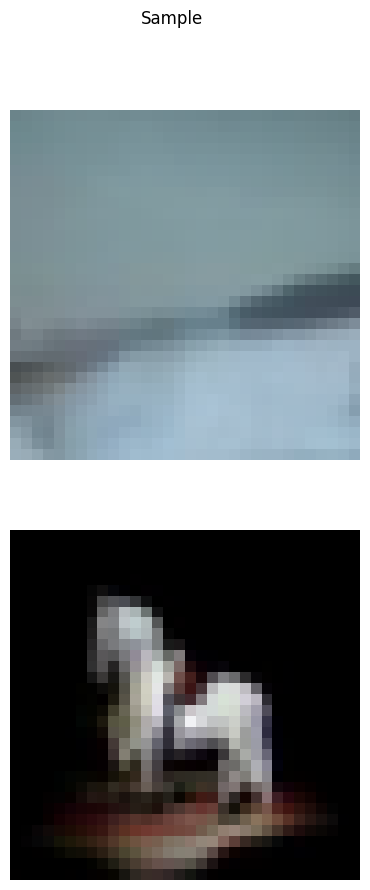

In [5]:
# num_sample_in_
def viz_sample(sample, title="Sample"):
    sample = sample.reshape((sample.shape[0], 32, 32, 3))
    sample = sample[:2]
    
    sample = (sample + 1) / 2
    sample = jnp.clip(sample, 0, 1)

    plt.figure(figsize=(10, 10))
    plt.suptitle(title)
    # for i in range(sample.shape[0]):
    #     plt.subplot(4, 4, i + 1)
    #     plt.imshow(sample[i])
    #     plt.axis("off")
    for i in range(sample.shape[0]):
        plt.subplot(2, 1, i + 1)
        plt.imshow(sample[i])
        plt.axis("off")
    plt.show()
viz_sample(sample)

Start 0 / 18


100%|██████████| 125/125 [00:26<00:00,  4.75it/s]


Error of mean:  [0.07377689 0.07052561 0.10107814 0.06033763 0.07362516 0.03925372
 0.07041639 0.07679206]
Total mean of error:  0.070725694


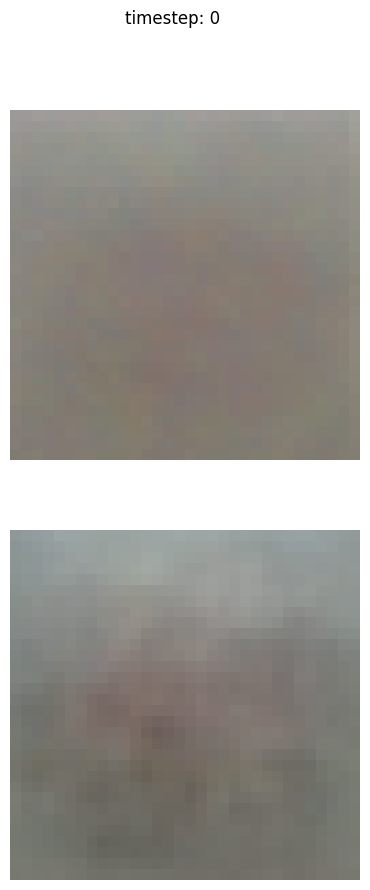

Start 1 / 18


100%|██████████| 125/125 [00:24<00:00,  5.02it/s]


Error of mean:  [0.06481691 0.05316432 0.04742516 0.05032031 0.06041467 0.08824324
 0.06128099 0.06959985]
Total mean of error:  0.06190818


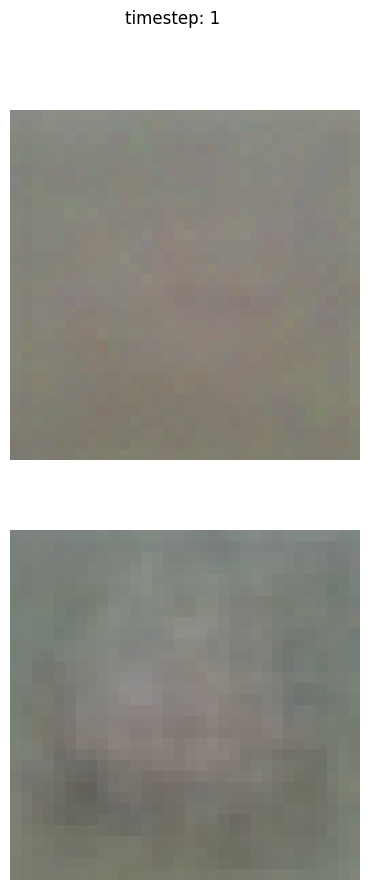

Start 2 / 18


100%|██████████| 125/125 [00:24<00:00,  5.08it/s]


Error of mean:  [0.16082704 0.15206021 0.06248925 0.05574641 0.1035227  0.05282761
 0.16399147 0.09982573]
Total mean of error:  0.1064113


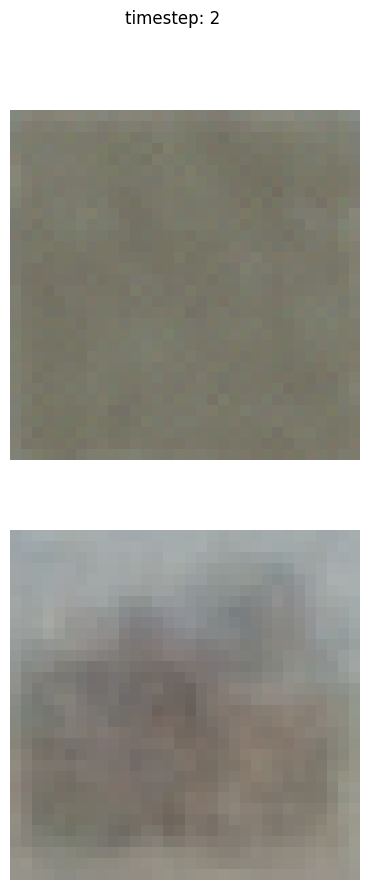

Start 3 / 18


100%|██████████| 125/125 [00:24<00:00,  5.04it/s]

Error of mean:  [0.05146717 0.07433401 0.06492981 0.05781319 0.06316756 0.06133522
 0.05476755 0.08064009]
Total mean of error:  0.06355683


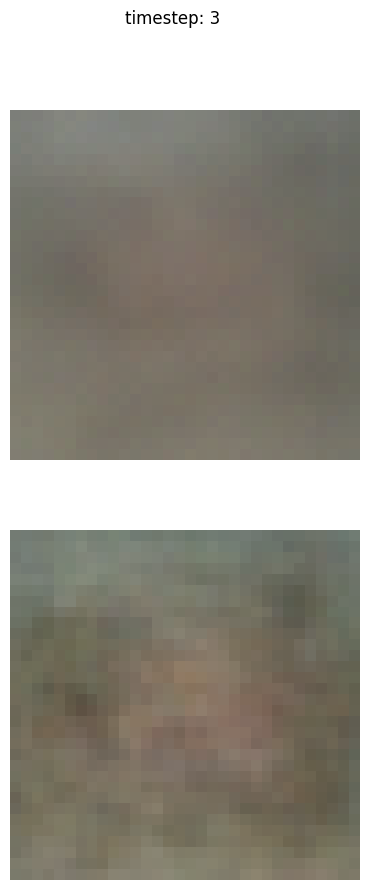

Start 4 / 18


100%|██████████| 125/125 [00:24<00:00,  5.12it/s]

Error of mean:  [0.05001819 0.0875386  0.08991705 0.07690133 0.08595206 0.05695847
 0.05485381 0.08725928]
Total mean of error:  0.07367485


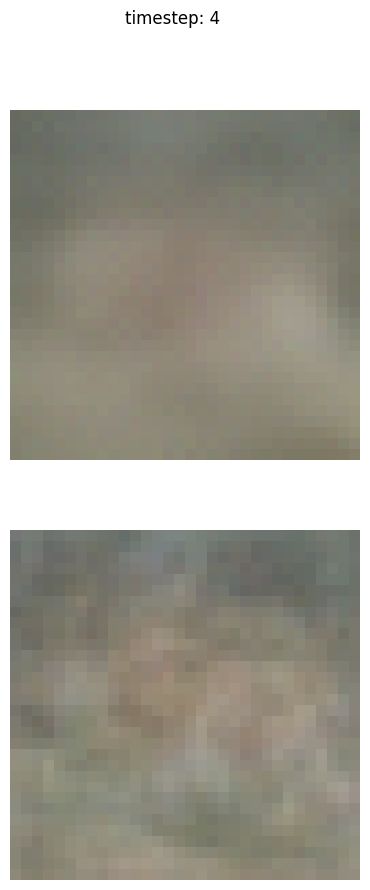

Start 5 / 18


100%|██████████| 125/125 [00:23<00:00,  5.23it/s]


Error of mean:  [0.07403789 0.1092927  0.16991445 0.10802385 0.11306983 0.11900727
 0.06838703 0.10721639]
Total mean of error:  0.10861868


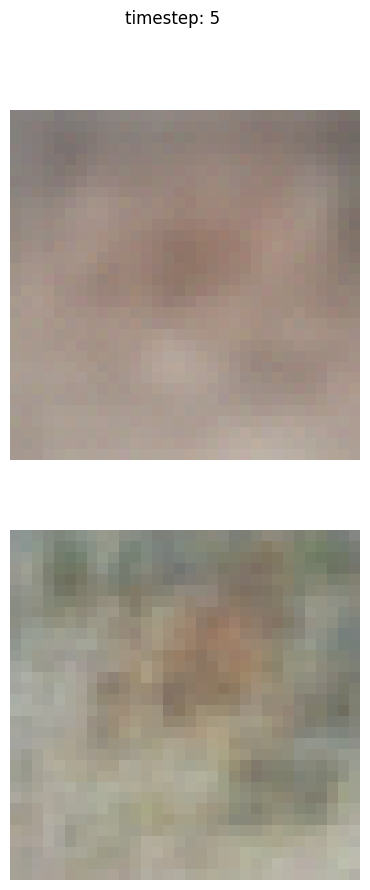

Start 6 / 18


100%|██████████| 125/125 [00:24<00:00,  5.08it/s]


Error of mean:  [0.08134674 0.15615034 0.13086115 0.12477504 0.12530634 0.13396026
 0.11977139 0.13861112]
Total mean of error:  0.1263478


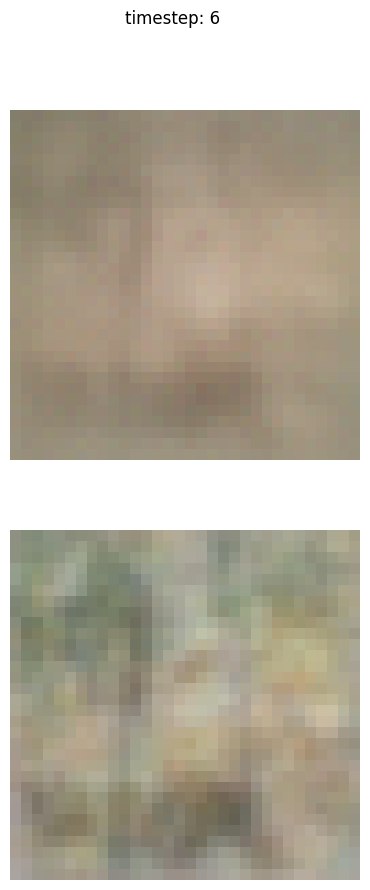

Start 7 / 18


100%|██████████| 125/125 [00:24<00:00,  5.17it/s]


Error of mean:  [0.1291973  0.16711323 0.14978859 0.18712676 0.12681836 0.15560776
 0.1345003  0.12034352]
Total mean of error:  0.14631198


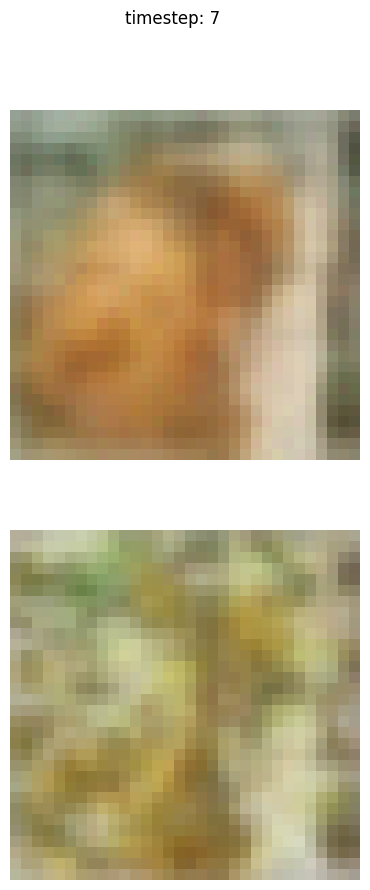

Start 8 / 18


100%|██████████| 125/125 [00:24<00:00,  5.20it/s]

Error of mean:  [0.17798011 0.17017804 0.18023583 0.16814628 0.16759667 0.12800978
 0.14269818 0.1185528 ]
Total mean of error:  0.15667471


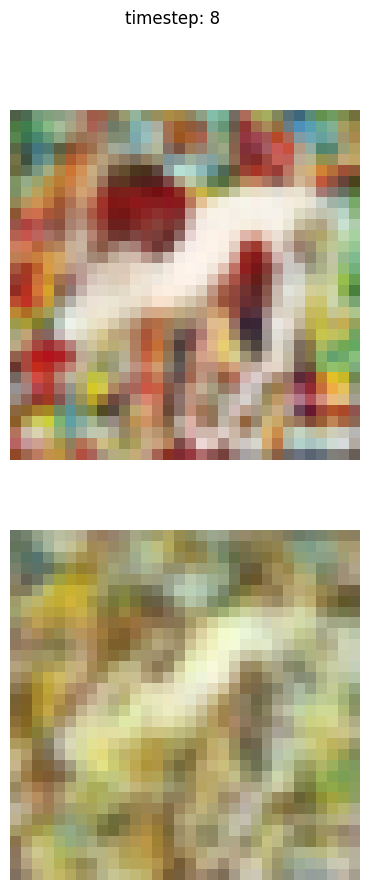

Start 9 / 18


100%|██████████| 125/125 [00:24<00:00,  5.09it/s]

Error of mean:  [0.16477485 0.18152002 0.16977203 0.17544053 0.18033342 0.19955692
 0.17171702 0.18850349]
Total mean of error:  0.17895228


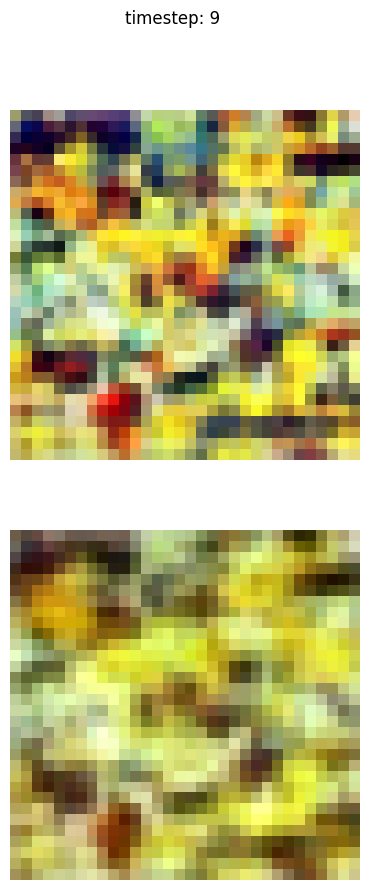

Start 10 / 18


100%|██████████| 125/125 [00:24<00:00,  5.13it/s]

Error of mean:  [0.14521262 0.15678243 0.15343331 0.15226208 0.150194   0.14629634
 0.14288926 0.15732978]
Total mean of error:  0.15054998


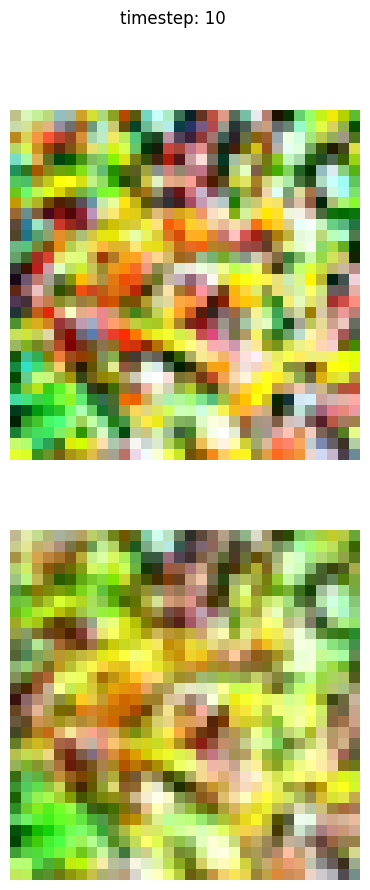

Start 11 / 18


100%|██████████| 125/125 [00:25<00:00,  4.99it/s]


Error of mean:  [0.10021974 0.10227749 0.10870469 0.10652031 0.10148335 0.09785493
 0.09978189 0.10644236]
Total mean of error:  0.1029106


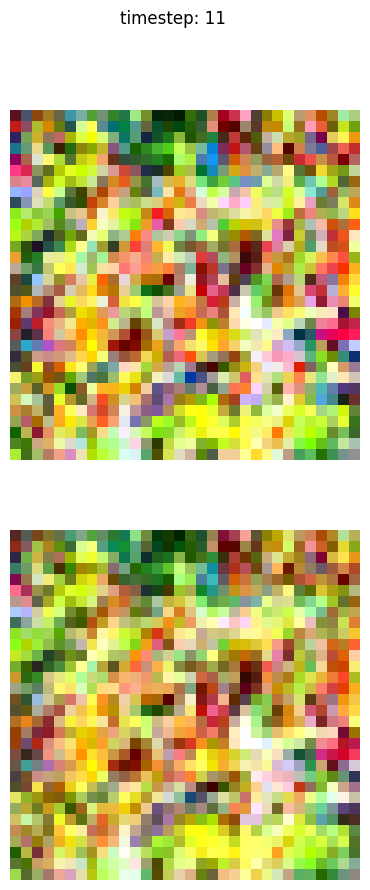

Start 12 / 18


100%|██████████| 125/125 [00:24<00:00,  5.16it/s]


Error of mean:  [0.05866544 0.06376803 0.06262609 0.06422846 0.06224519 0.05968797
 0.0603529  0.05899556]
Total mean of error:  0.061321206


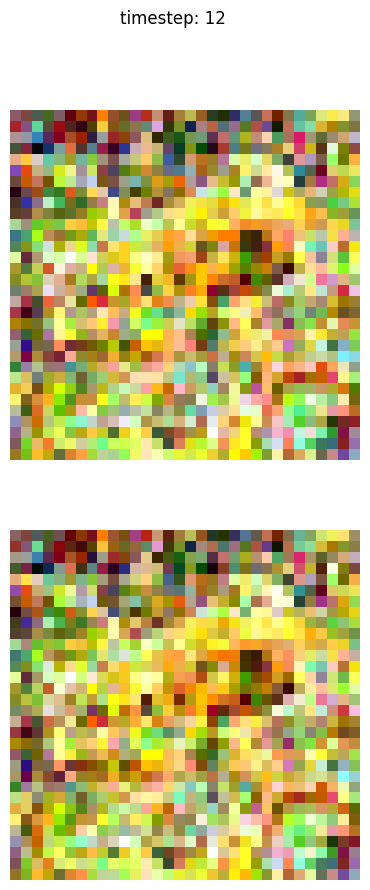

Start 13 / 18


100%|██████████| 125/125 [00:24<00:00,  5.09it/s]

Error of mean:  [0.03425914 0.03675053 0.03594876 0.03746428 0.03639964 0.03504076
 0.03468917 0.03571073]
Total mean of error:  0.035782874


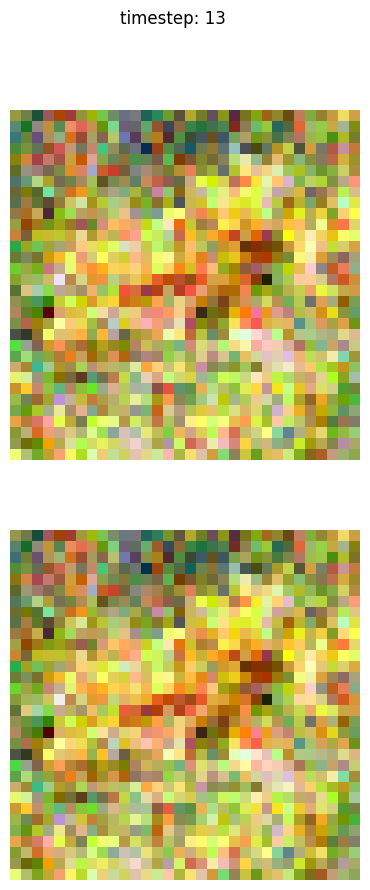

Start 14 / 18


100%|██████████| 125/125 [00:25<00:00,  4.96it/s]

Error of mean:  [0.02045464 0.02158052 0.02120185 0.02131094 0.02173203 0.02158182
 0.02104792 0.02198526]
Total mean of error:  0.021361873


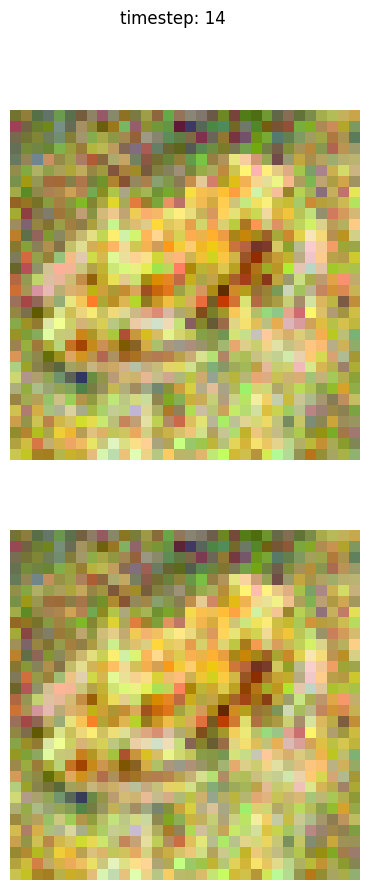

Start 15 / 18


100%|██████████| 125/125 [00:25<00:00,  4.95it/s]

Error of mean:  [0.0095803  0.01007022 0.01038405 0.01022422 0.01019295 0.01047929
 0.0101447  0.01045741]
Total mean of error:  0.010191644


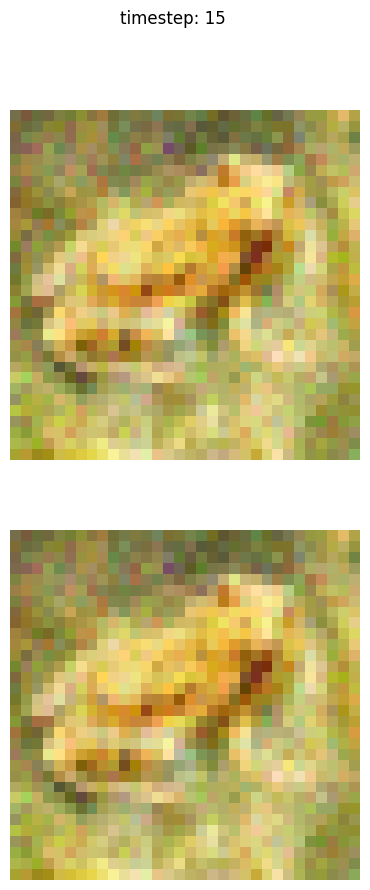

Start 16 / 18


100%|██████████| 125/125 [00:24<00:00,  5.06it/s]

Error of mean:  [0.00375555 0.00379478 0.0039063  0.00381034 0.00382695 0.00388994
 0.00386131 0.00393871]
Total mean of error:  0.0038479855


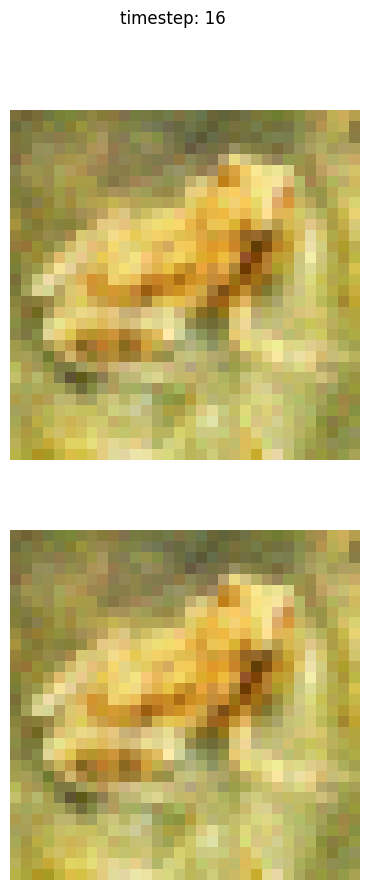

Start 17 / 18


100%|██████████| 125/125 [00:24<00:00,  5.02it/s]

Error of mean:  [0.00145526 0.00142382 0.00146409 0.00145147 0.00148144 0.00146638
 0.00146988 0.00146952]
Total mean of error:  0.0014602324


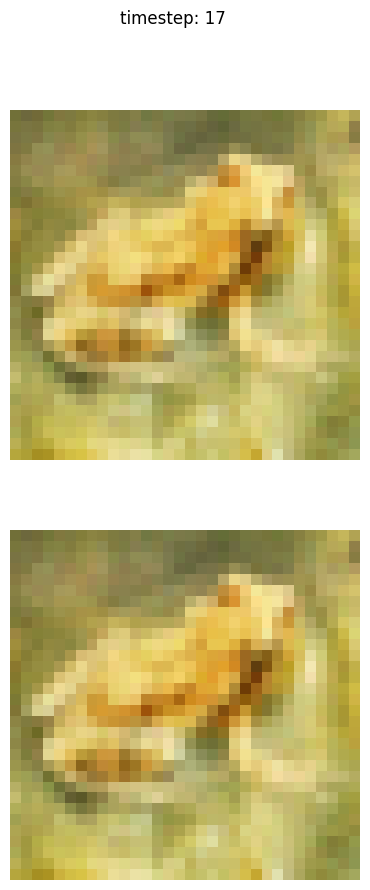

In [6]:
# The number of multiple datapoints
# num_sample = 1000
num_sample = 8000

data = next(datasets)
data = data[0][:, 0, ...] # 8 samples

# error_dict = {}
error_x_label = []
error_y_label = []

# tmp_timestep = 60
# for timestep in range(0, n_timestep, 6):
# for timestep in range(tmp_timestep, 1, -1):
for timestep in range(0, n_timestep):
# for timestep in range(n_timestep - 1, -1, -1):
    # if timestep == 18:
    #     timestep = 17
    # timestep = 9
    print(f"Start {timestep} / {n_timestep}")
    
    rng, sampling_rng = jax.random.split(rng)
    noise = jax.random.normal(sampling_rng, shape=data.shape) * t_steps[timestep]
    # noise = jax.random.normal(sampling_rng, shape=data.shape) * timestep

    # Get denoiser output
    denoiser_output = denoiser_framework.sampling_denoiser(data.shape[0], original_data=data, sweep_timesteps=timestep, noise=noise)

    # Get consistency output
    consistency_output = consistency_framework.sampling_cm_intermediate(data.shape[0], original_data=data, sweep_timesteps=timestep, noise=noise)
    consistency_output = jnp.expand_dims(consistency_output, axis=1)

    # Sample multiple datapoints
    sampling_list = []
    num_batch = num_sample // consistency_output.shape[0]
    for i in tqdm(range(num_batch)):
        rng, sampling_rng = jax.random.split(rng)
        new_noise = jax.random.normal(sampling_rng, shape=consistency_output.shape) * t_steps[timestep]
        # new_noise = jax.random.normal(sampling_rng, shape=consistency_output.shape) * timestep

        second_consistency_output = consistency_framework.sampling_cm_intermediate(
            data.shape[0], original_data=consistency_output, sweep_timesteps=timestep, noise=new_noise)
        second_consistency_output = jnp.expand_dims(second_consistency_output, axis=1)
        sampling_list.append(second_consistency_output)

    # sampling_list = jnp.concatenate(sampling_list, axis=0)
    sampling_list = jnp.stack(sampling_list, axis=0)
    second_consistency_output_empirical_mean = jnp.mean(sampling_list, axis=0)
    # denoiser_output_empirical_mean = jnp.mean(denoiser_output, axis=0)
    error = jnp.mean(jnp.abs(second_consistency_output_empirical_mean - denoiser_output), axis=(-1, -2, -3))
    # error = jnp.mean(jnp.abs(second_consistency_output_empirical_mean - data), axis=(-1, -2, -3))
    # error = jnp.mean(jnp.abs(second_consistency_output_empirical_mean - denoiser_output_empirical_mean))
    print("Error of mean: ", error.flatten())
    print("Total mean of error: ", jnp.mean(error))

    error_x_label.append(timestep)
    error_y_label.append(jnp.mean(error))

    viz_list = jnp.concatenate([denoiser_output[0], second_consistency_output_empirical_mean[0]], axis=0)
    viz_sample(viz_list, title=f"timestep: {timestep}")


In [7]:
total_error_mean = jnp.mean(jnp.array(error_y_label))
total_error_var = jnp.var(jnp.array(error_y_label))
print("Total error mean: ", total_error_mean)
print("Total error var: ", total_error_var)

Total error mean:  0.08225605
Total error var:  0.0029138972


Text(0.5, 0, 'Timestep')

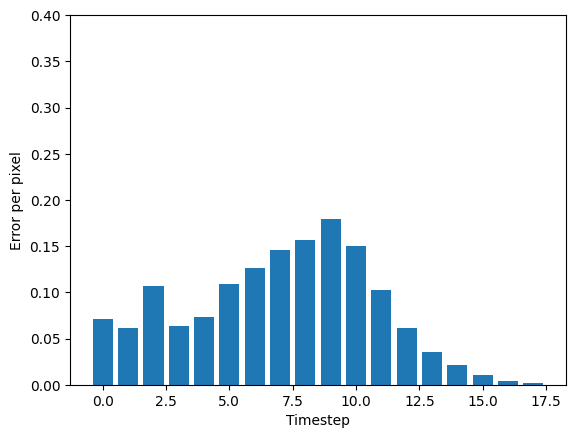

In [8]:
fig, ax = plt.subplots(1)

ax.bar(error_x_label, error_y_label)
y_max = 0.4
ax.set_ylim([0, y_max])
ax.set_ylabel("Error per pixel")
ax.set_xlabel("Timestep")



In [9]:
log_file_name = "compare_mean_log.txt"
with open(log_file_name, "a") as f:
    f.write(f"Exp name: {consistency_config['exp_name']}\n")
    f.write(f"Total error mean: {total_error_mean}\n")
    f.write(f"Total error var: {total_error_var}\n")
    f.write(f"Sigma max: {sigma_max}\n")
    f.write(f"Sigma min: {sigma_min}\n")
    f.write(f"Rho: {rho}\n")
    f.write(f"n_timestep: {n_timestep}\n")
    f.write(f"y_max: {y_max}\n")
    f.write("\n")
    f.write("\n")
    f.write("\n")

fig.savefig(f"{consistency_config['exp_name']}.png")